## Deconvolution Systems Design 

In this example we explore how the various deconvolution parameters, which we learned about in previous notebooks combine to affect deconvolution results.

###  Design trade-offs

1.  Iterations - more iterations provide a better result up to a point of diminishing returns.  How do we know when to stop? 
2.  PSF size - Using a larger PSF may improve deconvolution quality by increasing the spatial extent of the deblurring.  However a larger PSF size requires larger borders and larger overlap between chunks.  Note that the PSF size may be 'infinite' in thoeory (light from an emitter can propagate forever) however PSFs used for deconvolution are finite.  Thus the size of PSF used for deconvolution becomes a design parameter.
3.  Regularization - regularization can reduce noise in the output at a cost of slightly increased speed.  How do we know what regularization factor to use?  For the total variation regularization it is recommended to use values between 0.0001 and 0.005 [see this paper](https://pubmed.ncbi.nlm.nih.gov/16586486/) but the exact value can depend on the SNR of the image. 
4.  PSF - The quality of the Point Spread Function can affect final results.  If using a theoretical PSF we need to make sure the parameters used to generate the PSF match the true system parameters.
4.  Overlap - Larger overlaps will reduce artifacts, but increase processing time and memory by increasing the size of each chunk. 

### Simulation

In this example we do the following.

1.  Create a simulated image with a large sphere at the center and small spheres on the sides.  This sample is useful to study chunking artifacts because the chunks will subdivide the spheres. 

2.  Convolve a PSF with the simulated image and add noise.  

3.  Define our deconvolution parameters including PSF parameters, dask parameters, iterations and regularization factor then deconvolve. We generate 2 deconvolutions.  One with poor parameters (deconvolution PSF different than forward PSF, low iterations, no regularization, no overlap between subvolumes) and one with better parameters (deconvolution PSF = forward PSF, high iterations, overlap between sub-volumes and regularization used).  

### Exercise 1: Improve the deconvolution result.

(if running this exercise with students, hide the 'good parameter' deconvolution and let the students figure out how to generate it)
The parameters in this notebook are sub-optimal. First run the notebook then inspect the deconvolution result. To improve the deconvolution try the following

Inspect the PSF and make sure the forward PSF and decon PSF match, if not try adjusting the decon PSF parameters.
Change the number of iterations
Change the regularization factor
change the overlap between chunks


#### Exercise 2: Change the parameters of the simulation

Add more noise (hint Poisson noise is proportional to the number of photons, in this simulation try modifying the gain variable)
Try different PSFs (for example very low NA, even greater levels of aberration)
Try to create different types of phantom images, for example by drawing more spheres or different shapes.



# Imports 

In [2]:
%load_ext autoreload
%autoreload 2

import dask.array as da
from clij2fft.richardson_lucy import richardson_lucy_nc 
import numpy as np
import tnia.utility.decon_helper as dh
from tnia.deconvolution.forward import forward
from tnia.plotting.projections import show_xyz_slice, show_xyz_max

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
tnia available
stackview available


## Create the phantom

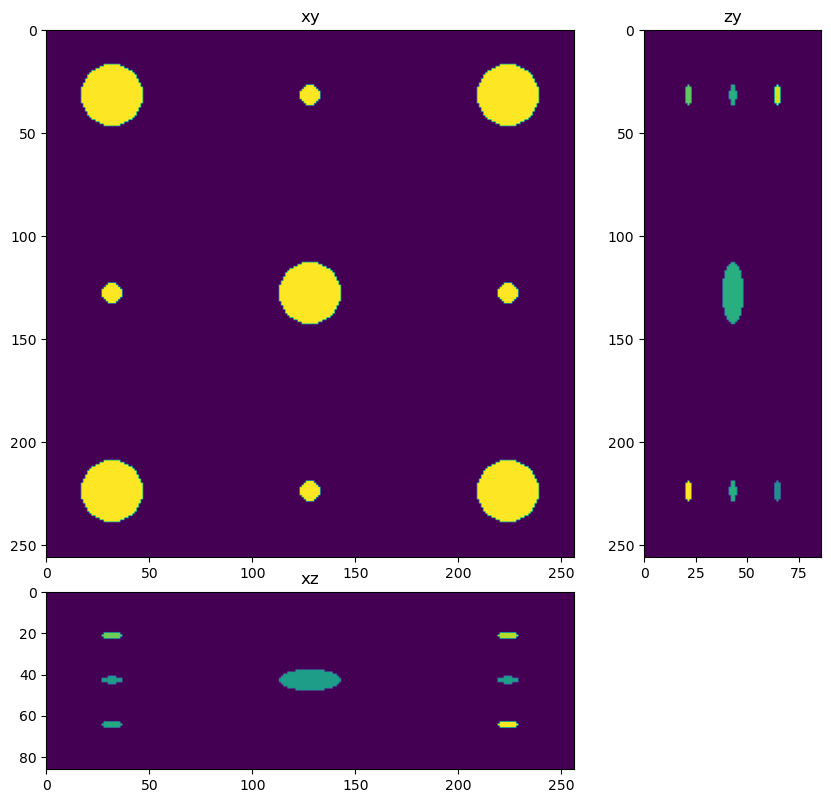

In [16]:
import raster_geometry as rg
from tnia.simulation.phantoms import add_small_to_large

gain = 400
background = 0 

zdim = 256
ydim = 256
xdim = 256

phantom = np.zeros((zdim,ydim,xdim), dtype=np.float32)

r=50
r_small=5
r_medium=15
size = [2*r, 2*r, 2*r]
size_small = [2*r_small, 2*r_small, 2*r_small]
size_medium = [2*r_medium, 2*r_medium, 2*r_medium]

sphere = rg.sphere(size, r).astype(np.float32)
small_sphere = rg.sphere(size_small, r_small).astype(np.float32)
medium_sphere = rg.sphere(size_medium, r_medium).astype(np.float32)

x=100
y=100
z=50

add_small_to_large(phantom, medium_sphere, phantom.shape[2]//2, phantom.shape[1]//2, phantom.shape[0]//2)

add_small_to_large(phantom, medium_sphere, phantom.shape[2]//8, phantom.shape[1]//8, phantom.shape[0]//2)
add_small_to_large(phantom, medium_sphere, phantom.shape[2]//8, 7*phantom.shape[1]//8, phantom.shape[0]//2)
add_small_to_large(phantom, medium_sphere, 7*phantom.shape[2]//8, phantom.shape[1]//8, phantom.shape[0]//2)
add_small_to_large(phantom, medium_sphere, 7*phantom.shape[2]//8, 7*phantom.shape[1]//8, phantom.shape[0]//2)

add_small_to_large(phantom, small_sphere, phantom.shape[2]//8, phantom.shape[1]//2, phantom.shape[0]//2)
add_small_to_large(phantom, small_sphere, 7*phantom.shape[2]//8, phantom.shape[1]//2, phantom.shape[0]//2)
add_small_to_large(phantom, small_sphere, phantom.shape[2]//2, phantom.shape[1]//8, phantom.shape[0]//2)
add_small_to_large(phantom, small_sphere, phantom.shape[2]//2, 7*phantom.shape[1]//8, phantom.shape[0]//2)

add_small_to_large(phantom, 1.4*small_sphere, phantom.shape[2]//8, phantom.shape[1]//2, phantom.shape[0]//4)
add_small_to_large(phantom, 1.6*small_sphere, 7*phantom.shape[2]//8, phantom.shape[1]//2, phantom.shape[0]//4)
add_small_to_large(phantom, 1.2*small_sphere, phantom.shape[2]//2, phantom.shape[1]//8, phantom.shape[0]//4)
add_small_to_large(phantom, 1.6*small_sphere, phantom.shape[2]//2, 7*phantom.shape[1]//8, phantom.shape[0]//4)

add_small_to_large(phantom, 1.1*small_sphere, phantom.shape[2]//8, phantom.shape[1]//2, 3*phantom.shape[0]//4)
add_small_to_large(phantom, 1.8*small_sphere, 7*phantom.shape[2]//8, phantom.shape[1]//2, 3*phantom.shape[0]//4)
add_small_to_large(phantom, 1.5*small_sphere, phantom.shape[2]//2, phantom.shape[1]//8, 3*phantom.shape[0]//4)
add_small_to_large(phantom, .8*small_sphere, phantom.shape[2]//2, 7*phantom.shape[1]//8, 3*phantom.shape[0]//4)

'''
add_small_to_large(phantom, sphere, phantom.shape[2]//2, phantom.shape[1]//2, phantom.shape[0]//2)

add_small_to_large(phantom, medium_sphere, phantom.shape[2]//8, phantom.shape[1]//8, phantom.shape[0]//2)
add_small_to_large(phantom, medium_sphere, phantom.shape[2]//8, 7*phantom.shape[1]//8, phantom.shape[0]//2)
add_small_to_large(phantom, medium_sphere, 7*phantom.shape[2]//8, phantom.shape[1]//8, phantom.shape[0]//2)
add_small_to_large(phantom, medium_sphere, 7*phantom.shape[2]//8, 7*phantom.shape[1]//8, phantom.shape[0]//2)

add_small_to_large(phantom, small_sphere, phantom.shape[2]//8, phantom.shape[1]//2, phantom.shape[0]//2)
add_small_to_large(phantom, small_sphere, 7*phantom.shape[2]//8, phantom.shape[1]//2, phantom.shape[0]//2)
add_small_to_large(phantom, small_sphere, phantom.shape[2]//2, phantom.shape[1]//8, phantom.shape[0]//2)
add_small_to_large(phantom, small_sphere, phantom.shape[2]//2, 7*phantom.shape[1]//8, phantom.shape[0]//2)

add_small_to_large(phantom, 1.4*small_sphere, phantom.shape[2]//8, phantom.shape[1]//2, phantom.shape[0]//4)
add_small_to_large(phantom, 1.6*small_sphere, 7*phantom.shape[2]//8, phantom.shape[1]//2, phantom.shape[0]//4)
add_small_to_large(phantom, 1.2*small_sphere, phantom.shape[2]//2, phantom.shape[1]//8, phantom.shape[0]//4)
add_small_to_large(phantom, 1.6*small_sphere, phantom.shape[2]//2, 7*phantom.shape[1]//8, phantom.shape[0]//4)

add_small_to_large(phantom, 1.1*small_sphere, phantom.shape[2]//8, phantom.shape[1]//2, 3*phantom.shape[0]//4)
add_small_to_large(phantom, 1.8*small_sphere, 7*phantom.shape[2]//8, phantom.shape[1]//2, 3*phantom.shape[0]//4)
add_small_to_large(phantom, 1.5*small_sphere, phantom.shape[2]//2, phantom.shape[1]//8, 3*phantom.shape[0]//4)
add_small_to_large(phantom, .8*small_sphere, phantom.shape[2]//2, 7*phantom.shape[1]//8, 3*phantom.shape[0]//4)
'''

phantom = phantom[::3,:,:]
phantom = phantom*gain
dh.show_xyz_slice(phantom, 'tnia')
# set title
#fig.suptitle('Phantom with z sub-sampling=3')

## Create the forward PSF and deconvolution PSF

Note that the forward PSF (the PSF that explains the image) is not equal to the digital PSF used for deconvolution.  Among other imperfect approximations the PSF used for deconvolution can have smaller spatial extent.  In this simulation the PSF we use for convolution (ie in the simulation) is different than the PSF used for deconvolution.  We can change the parameters of the deconvolution PSF to study how differences between the real PSF and the digital PSF we use for deconvolution affects the result. 

Two factors which are important but may also be only approximately known are the refractive index of the biological sample and the depth of the sample (below the cover lens).  These two factors combine to produce spherical aberration in the PSF.

If there is aberration in the true PSF of the system, to get a good deconvololution result that aberration must be matched in the sample. 

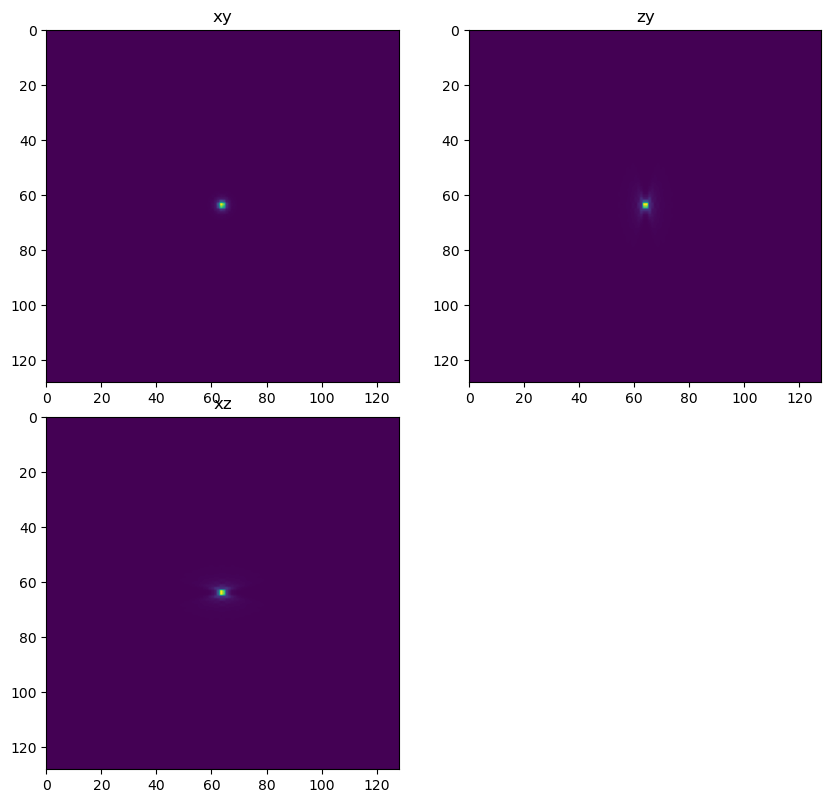

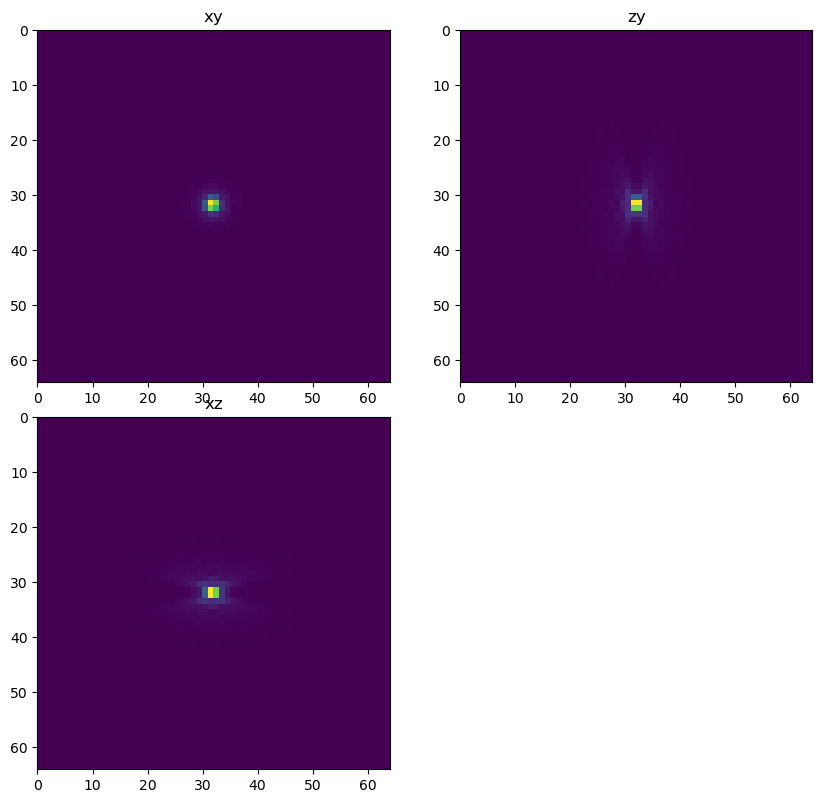

In [12]:
from tnia.deconvolution.psfs import gibson_lanni_3D

x_voxel_size = 0.1
z_voxel_size=0.3

sxy = 1
sz = z_voxel_size/x_voxel_size

xy_psf_dim_forward=128
z_psf_dim_forward=128

xy_psf_dim_decon=64
z_psf_dim_decon=64

NA=1.4

# ni is the refractive index of the immersion medium of the lens
ni=1.5
# ns is the refractive index of the sample
ns=1.33

# depth at which to calculate the PSF (note if there is a RI mismatch between the lens RI and sample RI spherical aberration will be introduced
# which will be depth dependent)
#depth_forward = 10
depth_forward = 0
depth_decon = 0 

psf_forward  = gibson_lanni_3D(NA, ni, ns, x_voxel_size, z_voxel_size, xy_psf_dim_forward, z_psf_dim_forward, depth_forward, 0.5, False, True)
psf_forward = psf_forward.astype('float32')
psf_forward = psf_forward/psf_forward.sum()
dh.show_xyz_slice(psf_forward, 'tnia')

psf_decon  = gibson_lanni_3D(NA, ni, ns, x_voxel_size, z_voxel_size, xy_psf_dim_decon, z_psf_dim_decon, depth_decon, 0.5, False, True)
psf_decon = psf_decon.astype('float32')
psf_decon = psf_decon/psf_decon.sum()
dh.show_xyz_slice(psf_decon, 'tnia')

## Apply the forward model

In this case the forward model is convolution with the PSF and the addition of Poisson noise.  

What other factors will cause error between the true shape of the sample and the acquired image? 

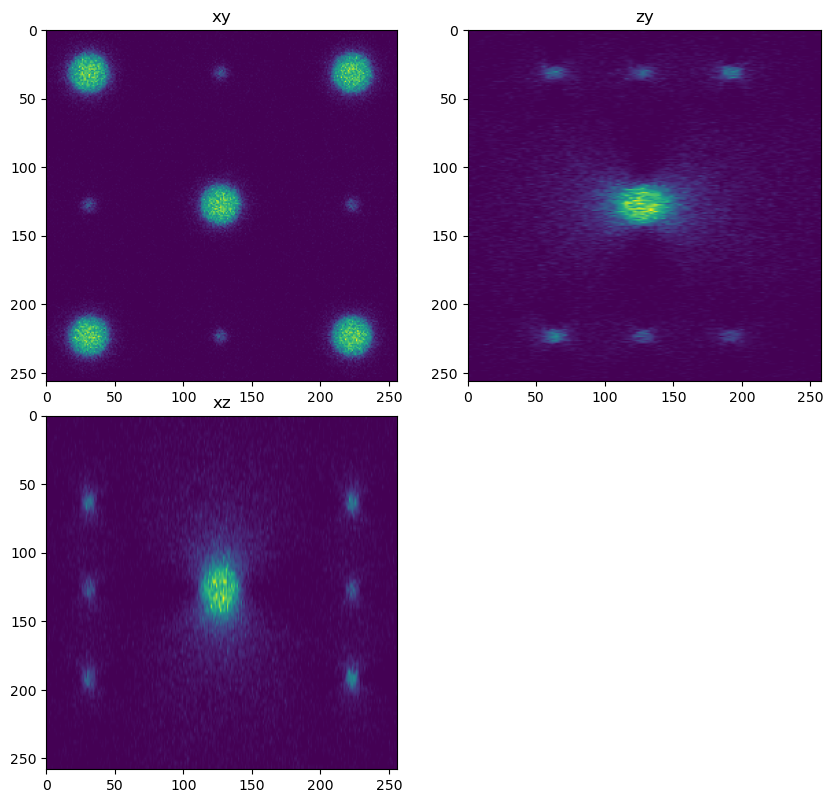

In [17]:
from tnia.deconvolution.forward import forward
from tnia.nd.ndutil import centercrop

im = forward(phantom, psf_forward, background, True, True)

x_v = im.shape[2]//2
y_v = im.shape[1]//2
z_v = im.shape[0]//2

phantom=phantom+background

fig = show_xyz_slice(im, x_v, y_v, z_v, sxy=sxy, sz=sz)

In [18]:
from skimage.io import imsave

imsave('../../data/deconvolution/simulation/phantom_3.tif', phantom)
imsave('../../data/deconvolution/simulation/im_no_aberration_3.tif', im)

C:\Users\bnort\AppData\Local\Temp\ipykernel_18764\1967920504.py:3: UserWarning: ../../data/deconvolution/simulation/phantom_3.tif is a low contrast image
  imsave('../../data/deconvolution/simulation/phantom_3.tif', phantom)


## Define number of chunks

Define the number of chunks to divide the image into. 

(In this example the image is relatively small so likely the image and arrays needed for FFT based calculations would fit into the GPU without chunking, in a real life example we would pre-compute the largest chunk size we could process given memory constraints and base the chunk size on that).

In [19]:
num_x_chunks = 2 
num_y_chunks = 2
num_z_chunks = 1

z_chunk_size = im.shape[0]
y_chunk_size = int(im.shape[1]/num_x_chunks)
x_chunk_size = int(im.shape[2]/num_y_chunks)
print('chunks', z_chunk_size, y_chunk_size, x_chunk_size)


chunks 86 128 128


## Define the deconvolver

Define either a clij2fft based, or if clij2fft is not installed a redlionfish based Richardson Lucy deconvolution function.  We map both libraries to the same deconvolution interface to make it easier to call either version in the dask step. 

In [20]:
try:
    from clij2fft.richardson_lucy import richardson_lucy_nc 
    def deconv_chunk(img, psf, iterations=100, reg=0):
            print('iterations+reg',iterations, reg)
            print('deconvolving chunk with size',img.shape)
            result = richardson_lucy_nc(img, psf, iterations, reg)
            print('/nfinished decon chunk')
            return result
            #return stack
    print('clij2fft non-circulant rl imported')
except ImportError:
    print('clij2fft non-circulant rl not imported')
    try:
        import RedLionfishDeconv as rl
        print('redlionfish rl imported')
        def deconv_chunk(img, psf, iterations, reg):
            print(img.shape,psf_decon.shape)
            result = rl.doRLDeconvolutionFromNpArrays(img, psf, niter=iterations, method='gpu', resAsUint8=False )
            print('finished decon chunk')
            return result
    except ImportError:
        print('redlionfish rl not imported')



clij2fft non-circulant rl imported


## Deconvolve in chunks 

Here we call the dask deconvolution using an overlap factor to prevent edge artifacts between chunks.  We try both of a set of sub-optimal parameters, and a set of better parameters to study how different settings affect deconvolution quality.

Note:  Depending on the GPU memory available you may or may not need to process using Chunks.  However the purpose of the notebook is to examine how various settings (including chunking settings) affect the deconvolution result, so that when we do have very large image sizes, and have to use chunking, we understand how to use chunks optimally. 

iterations+reg 50 0
deconvolving chunk with size (0, 0, 0)
iterations+reg 50 0
deconvolving chunk with size (86, 128, 128)
get lib
/nfinished decon chunk
iterations+reg 50 0
deconvolving chunk with size (86, 128, 128)
get lib
/nfinished decon chunk
iterations+reg 50 0
deconvolving chunk with size (86, 128, 128)
get lib
/nfinished decon chunk
iterations+reg 50 0
deconvolving chunk with size (86, 128, 128)
get lib
/nfinished decon chunk
iterations+reg 500 0.0005
deconvolving chunk with size (0, 0, 0)
iterations+reg 500 0.0005
deconvolving chunk with size (86, 153, 153)
get lib
/nfinished decon chunk
iterations+reg 500 0.0005
deconvolving chunk with size (86, 153, 153)
get lib
/nfinished decon chunk
iterations+reg 500 0.0005
deconvolving chunk with size (86, 153, 153)
get lib
/nfinished decon chunk
iterations+reg 500 0.0005
deconvolving chunk with size (86, 153, 153)
get lib
/nfinished decon chunk


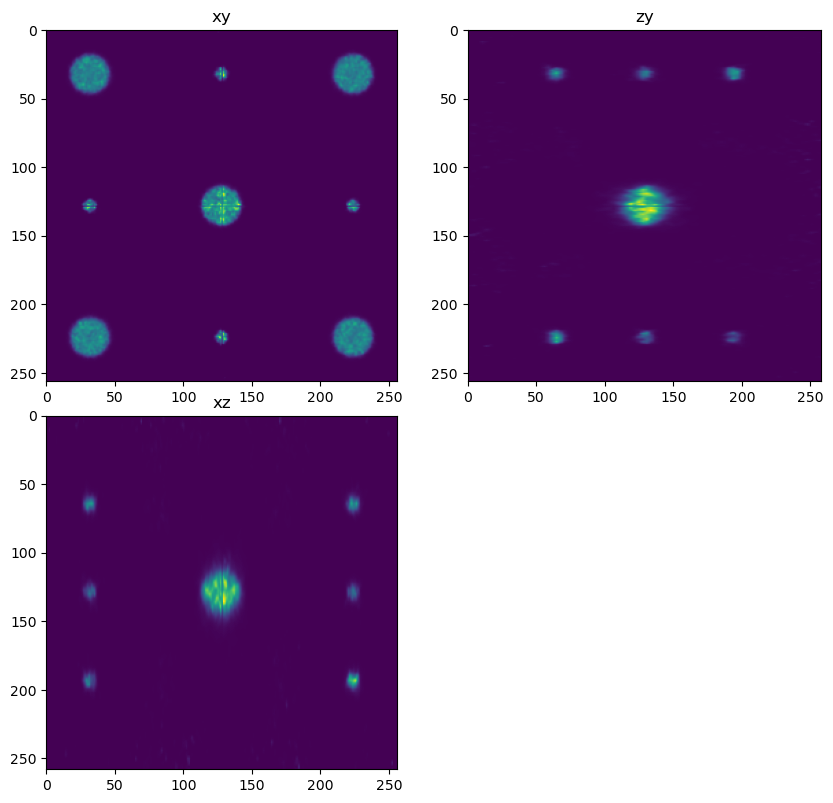

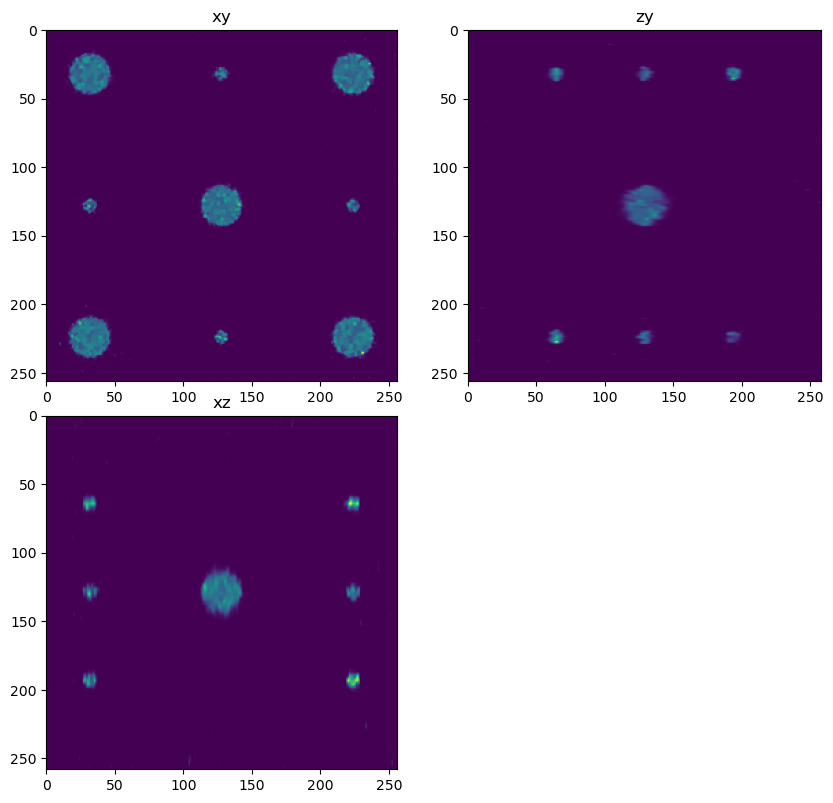

In [21]:

overlap = 0
dimg = da.from_array(im,chunks=(z_chunk_size, y_chunk_size, x_chunk_size))
out1 = dimg.map_overlap(deconv_chunk, depth={0:0, 1:overlap, 2:overlap}, dtype=np.float32, psf=psf_decon, iterations=50, reg=0)
decon1 = out1.compute(num_workers=1)


overlap = 25
out2 = dimg.map_overlap(deconv_chunk, depth={0:0, 1:overlap, 2:overlap}, dtype=np.float32, psf=psf_forward, iterations=500, reg=0.0005)
decon2 = out2.compute(num_workers=1)

fig = show_xyz_slice(decon1, x_v, y_v, z_v, sxy=sxy, sz=sz)
fig = show_xyz_slice(decon2, x_v, y_v, z_v, sxy=sxy, sz=sz)

## Look at error

In [22]:
from tnia.metrics.errors import RMSE

print('RMSE (phantom, phantom)', RMSE(phantom, phantom))
print('RMSE (phantom, im)', RMSE(phantom, im))
print('RMSE (phantom, decon 1)', RMSE(phantom, decon1))
print('RMSE (phantom, decon 2)', RMSE(phantom, decon2))

RMSE (phantom, phantom) 0.0
RMSE (phantom, im) 26.038565
RMSE (phantom, decon 1) 17.238834
RMSE (phantom, decon 2) 10.641857


## Segment the spheres

In [23]:
# import otsu
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops

def segmenter(im, min_area=0):
    
    binary = im>threshold_otsu(im)
    labels = label(binary) 
    
    # get the regions
    object_list = regionprops(labels,im)

    filtered_objects = []
    labels_filtered = np.zeros_like(labels)

    if min_area==0:
        return object_list, labels
    
    else:
        for obj in object_list:
            
            if obj.area > min_area:
                labels_filtered[labels==obj.label]=obj.label
                filtered_objects.append(obj)
        return filtered_objects, labels_filtered

In [24]:
objects_truth, labels_truth = segmenter(phantom, 20)
objects_im, labels_im = segmenter(im, 20)
objects_decon1, labels_decon1 = segmenter(decon1, 20)
objects_decon2, labels_decon2 = segmenter(decon2, 20)

print('objects_truth', len(objects_truth))
print('objects_im', len(objects_im))
print('objects_decon', len(objects_decon1))
print('objects_decon', len(objects_decon2))


objects_truth 17
objects_im 17
objects_decon 17
objects_decon 17


## Make figures of segmentations

In [25]:
from tnia.plotting.projections import show_xy_xz_slice
from tnia.plotting.projections import show_xy_xz
from matplotlib import pyplot as plt

from tnia.plotting.projections import show_xy_zy_slice
from tnia.plotting.plt_helper import random_label_cmap

def makefigs():
    fig1=show_xy_xz_slice(labels_im, x_v, y_v, z_v, sxy=sxy, sz=sz,figsize=(4,9), colormap=random_label_cmap())
    fig1.suptitle('Segmentation of image')
    fig2=show_xy_xz_slice(labels_decon1, x_v, y_v, z_v, sxy=sxy, sz=sz,figsize=(4,9), colormap=random_label_cmap())
    fig2.suptitle('Segmentation of mediocre decon')
    fig3=show_xy_xz_slice(labels_decon2, x_v, y_v, z_v, sxy=sxy, sz=sz,figsize=(4,9), colormap=random_label_cmap())
    fig3.suptitle('Segmentation of better decon')
    fig1.savefig('labels_im.png')
    fig2.savefig('labels_decon1.png')
    fig3.savefig('labels_decon2.png')
    plt.close(fig1)
    plt.close(fig2)
    plt.close(fig3)

makefigs()



## Segmentation results

It was a bit tricky to get side by side XY/XZ views of the results (this is the most space efficient means to view the images).  By default new images seem to be rendered below the previous one in notebooks.  So we saved the projection as .png files then used some html to render them (double click on this cell to see the html)

<div>
    <img src="labels_im.png?version=foo" width="300">
    <img src="labels_decon1.png?version=foo2" width="300">
    <img src="labels_decon2.png?version=foo3" width="300">
</div>

In [26]:
#  print size and intensity of each object
for obj in objects_truth:
    # if object index is not 0
    if obj.label != 1:
        print('truth', obj.area, obj.mean_intensity)

print()

for obj in objects_im:
    if obj.label != 1:
        print('im', obj.area, obj.mean_intensity)

print()

for obj in objects_decon1:
    if obj.label != 1:
        print('decon 1', obj.area, obj.mean_intensity)

print()

for obj in objects_decon2:
    if obj.label != 1:
        print('decon 2', obj.area, obj.mean_intensity)
    

truth 184.0 560.0
truth 184.0 640.0
truth 184.0 640.0
truth 4808.0 400.0
truth 4808.0 400.0
truth 4808.0 400.0
truth 4808.0 400.0
truth 4808.0 400.0
truth 184.0 400.0
truth 184.0 400.0
truth 184.0 400.0
truth 184.0 400.0
truth 184.0 600.0
truth 184.0 440.0
truth 184.0 720.0
truth 184.0 320.0

im 219.0 18.287672
im 221.0 18.190044
im 156.0 17.160257
im 11786.0 24.726456
im 11749.0 24.759724
im 11746.0 24.762558
im 11798.0 24.692999
im 11812.0 24.699036
im 70.0 15.185715
im 66.0 15.651515
im 65.0 15.292308
im 71.0 15.591549
im 192.0 17.817709
im 233.0 19.802574
im 106.0 15.537736
im 33.0 14.515152

decon 1 155.0 227.52074
decon 1 190.0 275.37866
decon 1 164.0 255.94493
decon 1 190.0 278.8845
decon 1 4571.0 217.92438
decon 1 3768.0 181.85344
decon 1 3794.0 182.07584
decon 1 3745.0 183.23639
decon 1 3749.0 183.26329
decon 1 143.0 201.34668
decon 1 146.0 191.83151
decon 1 134.0 202.05724
decon 1 140.0 200.79266
decon 1 194.0 253.84734
decon 1 205.0 297.4484
decon 1 146.0 217.55595
decon 1 1

# View in Napari

In [11]:
import napari
viewer = napari.Viewer()
viewer.add_image(phantom, scale=[3,1,1],name='phantom')
viewer.add_image(im, scale=[3,1,1],name='im')
viewer.add_image(decon1, scale=[3,1,1],name='decon 1')
viewer.add_image(decon2, scale=[3,1,1],name='decon 2')
viewer.add_labels(labels_im, scale=[3,1,1],name='labels_im')
viewer.add_labels(labels_decon1, scale=[3,1,1],name='labels_decon 1')
viewer.add_labels(labels_decon2, scale=[3,1,1],name='labels_decon 2')


<Labels layer 'labels_decon 2' at 0x7f89933aefd0>